# **NGUYỄN VŨ TƯỜNG @CHALLESVU**

## Thu thập dữ liệu

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd

### Vinmec

In [ ]:
BASE_URL = "https://www.vinmec.com/vie/hoi-dap-bac-si/{}/page_{}"
BASE_URL_NEXT = "https://www.vinmec.com"

tags = [
    'chan-thuong-chinh-hinh-y-hoc-the-thao',
    'trung-tam-cong-nghe-cao',
    'trung-tam-nhi',
    'trung-tam-suc-khoe-phu-nu',
    'trung-tam-vu',
    'tim-mach',
    'ung-buou',
    'y-hoc-co-truyen'
]

with open('qna_vinmec.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Question", "Answer"])

for tag in tags:
    page = 1    
    post_url = set()
    while page <= 400:
        url = BASE_URL.format(tag, page)
        try:
            response = requests.get(url)

            soup = BeautifulSoup(response.text, 'html.parser')
            div_tags = soup.find_all('div', class_='col-3')

            if not div_tags:
                print(f"No content on page {page} for tag {tag}. Moving to the next tag.")
                break

            for div in div_tags:
                a_tags = div.find_all('a', class_='thumbblock')
                for a in a_tags:
                    post_url.add(a['href'])
            
            page += 1
        except requests.exceptions.RequestException as e:
            print(f"Error fetching page {page} for tag {tag}: {e}")
            break  
    
    print(tag)
    for pu in post_url:
        print(pu)
        try:
            response = requests.get(BASE_URL_NEXT + pu)
            soup = BeautifulSoup(response.text, 'html5lib')

            div = soup.find('div', id='main-article')
            all_p_tags = div.find_all('p')

            question = ""
            answer = ""
            is_question = False
            is_answer = False

            for p in all_p_tags:
                text = p.get_text().strip()

                if "Hỏi" in text:
                    is_question = True
                    is_answer = False
                    question = text.replace("Hỏi", "").strip()

                elif "Trả lời" in text:
                    is_question = False
                    is_answer = True
                    continue
                
                if is_question:
                    question += " " + text
                
                if is_answer:
                    if "Trân trọng!" in text:
                        answer += "" + text.split("Trân trọng!")[0]
                        break
                    else:
                        answer += "" + text

            question = question.replace("Hỏi", "").strip()
            answer = answer.replace("Trả lời", "").strip()

            if question == "":
                break

            with open('qna_vinmec.csv', mode='a', newline='', encoding='utf-8') as file:
                        writer = csv.writer(file)
                        writer.writerow([question, answer])
        except requests.exceptions.RequestException as e:
            print(f"Error fetching content from {tag}: {e}") 

In [ ]:
file_path = 'qna_vinmec.csv'

df = pd.read_csv(file_path)

df_cleaned = df.dropna(subset=['Question', 'Answer'])
df_cleaned = df_cleaned.drop_duplicates(subset=['Question', 'Answer'])

output_path = 'qna_vinmec_4k3.csv'
df_cleaned.to_csv(output_path, index=False)

### Edoctor

In [ ]:
newsfeed_url_template = "https://cms.edoctor.io/newsfeeds?_limit=10&_start={}"

with open('qna_edoctor.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Question", "Answer"])

start = 0
while start <= 4310:
    url = newsfeed_url_template.format(start)
    try:
        response = requests.get(url)
        data = response.json()
        newsfeeds = data.get('newsfeeds', [])

        if not newsfeeds:
            print("Done")
            break

        for item in newsfeeds:
            question = item.get('question', {})
            if question:
                content = question.get('content', '')
                comments = question.get('comments', '')
                with open('qna_edoctor.csv', mode='a', newline='', encoding='utf-8') as file:
                    writer = csv.writer(file)
                    writer.writerow([content, comments])
                    
    except requests.exceptions.RequestException as e:
        print(str(e)) 

    start += 10

In [ ]:
file_path = 'qna_edoctor.csv'

df = pd.read_csv(file_path)

df_cleaned = df.drop_duplicates(subset=['Question', 'Answer'])

output_path = 'qna_edoctor_cleaned.csv'
df_cleaned.to_csv(output_path, index=False)

### Tâm Anh

In [ ]:
base_url = 'https://tamanhhospital.vn/chu-de-tu-van/tu-van/page/{}/'

page = 1
max_pages = 354
tails = set()

while page <= max_pages:
    url = base_url.format(page)
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        div_tags = soup.find_all('div', class_='box_tuvan pl_15 pr_15 pt_15 pb_15 bg_white')

        if not div_tags:
            print("Done")
            print(page)
            break
        
        for div in div_tags:
            a_tag = div.find('a')
            if a_tag:
                href = a_tag['href']
                tails.add(href)

    except requests.exceptions.RequestException as e:
        print(str(e))
        break
    
    page += 1

with open('qna_tamanh.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Question", "Answer"])

unique_qna = set()
for tail in tails:
    try:
        questionPublic = ''
        answerPublic = ''

        response = requests.get(tail)
        soup = BeautifulSoup(response.text, 'html.parser')
        div_tags = soup.find_all('div', class_='mt_10')
        for div in div_tags:
            questionPublic = div.text.strip()
        
        div_tags_2 = soup.find_all('div', class_='bg_xam tuvan_detail pl_15 pr_15 pt_45 pb_15 mt_25tr')
        for div in div_tags_2:
            p_tags = div.find_all('p')
            answerPublic = " ".join([p.text.strip() for p in p_tags])
        if questionPublic and answerPublic:
            if (questionPublic, answerPublic) not in unique_qna:
                unique_qna.add((questionPublic, answerPublic))
                with open('qna_tamanh.csv', mode='a', newline='', encoding='utf-8') as file:
                    writer = csv.writer(file)
                    writer.writerow([questionPublic, answerPublic])

    except requests.exceptions.RequestException as e:
        print(str(e))
        break

In [ ]:
tamanh_data = pd.read_csv("qna_tamanh.csv")

def clean_answer(text):
    marker1 = "Nếu còn bất kỳ thắc mắc"
    marker2 = "Nếu có thêm bất kỳ thắc mắc"
    marker3 = "Nếu có thêm bất cứ thắc mắc"
    marker4 = "Nếu có bất kỳ thắc mắc nào"
    marker5 = "Để đặt lịch khám"

    if marker1 in text:
        text = text.split(marker1)[0].strip()
    elif marker2 in text:
        text = text.split(marker2)[0].strip()
    elif marker3 in text:
        text = text.split(marker3)[0].strip()
    elif marker4 in text:
        text = text.split(marker4)[0].strip()

    if marker5 in text:
        text = text.split(marker5)[0].strip()

    return text

tamanh_data['Answer'] = tamanh_data['Answer'].apply(clean_answer)
df_unique = tamanh_data.drop_duplicates(subset=['Question', 'Answer'], keep='first')
df_unique['Answer'] = df_unique['Answer'].str.replace('HỆ THỐNG BỆNH VIỆN ĐA KHOA TÂM ANH', '', regex=False)

output_file_path = 'qna_tamanh_3k5.csv'
df_unique.to_csv(output_file_path, index=False)

### Bookingcare

In [ ]:
url_template = 'https://bookingcare.vn/api/community/getlistcommunity?camelCase=1&trang={}&gioihan=100'

with open('bookingcare_qna_700.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Question", "Answer"])

start = 1
unique_qna = set()
while start <= 8:
        url = url_template.format(start)
        try:
            response = requests.get(url)
            data = response.json()
            newsfeeds = data.get('dulieu', [])

            if not newsfeeds:
                print("Done")
                break

            for item in newsfeeds:
                question = item.get('questionPublic', '')
                answer = item.get('answerPublic', '')
                
                if (question, answer) not in unique_qna:
                    unique_qna.add((question, answer))
                    with open('bookingcare_qna_700.csv', mode='a', newline='', encoding='utf-8') as file:
                        writer = csv.writer(file)
                        writer.writerow([question, answer])
                        
        except requests.exceptions.RequestException as e:
            print(str(e)) 

        start += 1

## Xử lý dữ liệu và huấn luyện mô hình

In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from sklearn.model_selection import train_test_split

In [74]:
df_bookingcare = pd.read_csv('qna_bookingcare_700.csv')
df_edoctor = pd.read_csv('qna_edoctor_4k3.csv')
df_tamanh = pd.read_csv('qna_tamanh_3k5.csv')
df_vinmec = pd.read_csv('qna_vinmec_4k3.csv')

df_combined = pd.concat([df_bookingcare, df_edoctor, df_tamanh, df_vinmec], ignore_index=True)

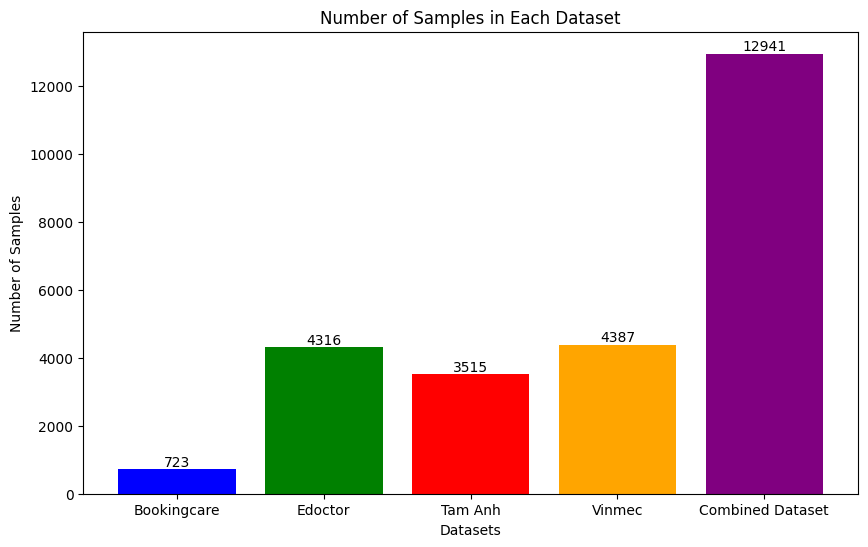

In [3]:
import matplotlib.pyplot as plt

count_bookingcare = len(df_bookingcare)
count_edoctor = len(df_edoctor)
count_tamanh = len(df_tamanh)
count_vinmec = len(df_vinmec)
count_combined = len(df_combined)

datasets = ['Bookingcare', 'Edoctor', 'Tam Anh', 'Vinmec', 'Combined Dataset']
counts = [count_bookingcare, count_edoctor, count_tamanh, count_vinmec, count_combined]

plt.figure(figsize=(10, 6))
bars = plt.bar(datasets, counts, color=['blue', 'green', 'red', 'orange', 'purple'])
plt.title('Number of Samples in Each Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Datasets')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.show()

In [75]:
train_df, test_df = train_test_split(df_combined, test_size=0.1) 

In [77]:
len(test_df)

1295

In [4]:
def preprocess_data(df, tokenizer):
    input_texts = ["hỏi: " + question for question in df['Question']]
    target_texts = ["trả lời: " + answer for answer in df['Answer']]
    model_inputs = tokenizer(input_texts, max_length=512, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target_texts, max_length=512, padding="max_length", truncation=True)["input_ids"]

    return {
        "input_ids": model_inputs["input_ids"],
        "attention_mask": model_inputs["attention_mask"],
        "labels": labels
    }

In [5]:
class MedicalQADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.encodings['labels'][idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [5]:
from transformers import get_scheduler
from tqdm.auto import tqdm

def train(model, train_dataset, valid_dataset, optimizer, device, num_epochs=10, batch_size=8, gradient_accumulation_steps=2, patience=3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    num_training_steps = num_epochs * len(train_loader) // gradient_accumulation_steps
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    model.to(device)
    model.train()

    best_loss = float('inf')  
    epochs_no_improve = 0    

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
        
        for step, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps

            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.item() * gradient_accumulation_steps
            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

        valid_loss = evaluate(model, valid_loader, device)
        print(f"Validation loss after epoch {epoch + 1}: {valid_loss:.4f}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            epochs_no_improve = 0
            print("Validation loss improved. Saving the model...")
            torch.save(model.state_dict(), 'medical_bot.pth')
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s)")
        
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch + 1} epochs due to no improvement in validation loss.")
            break

        print("=" * 50)

def evaluate(model, valid_loader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            num_batches += 1

    model.train()
    return total_loss / num_batches

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [3]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")

C:\Users\ADMINS\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
model1 = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")
model2 = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")
model3 = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")
model4 = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")
model42 = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")

Model trained with 'qna_edoctor_4k3.csv' and 'qna_vinmec_4k3.csv'

In [4]:
model1.load_state_dict(torch.load('medicalBot_ver1.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Model trained with 'qna_edoctor_4k3.csv', 'qna_vinmec_4k3.csv', and 'qna_bookingcare_700.csv'

In [5]:
model2.load_state_dict(torch.load('medicalBot_ver2.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Model trained with 'qna_edoctor_4k3.csv', 'qna_vinmec_4k3.csv', 'qna_bookingcare_700.csv', and 'qna_tamanh_3k5.csv'

In [6]:
model3.load_state_dict(torch.load('medicalBot_ver3.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
state_dict = torch.load('medicalBot_ver4.pth', map_location=torch.device('cpu'))
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    new_state_dict[name] = v
model4.load_state_dict(new_state_dict)

<All keys matched successfully>

In [8]:
model42.load_state_dict(torch.load('medicalBot_ver4_2.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
train_encoded = preprocess_data(train_df, tokenizer)
valid_encoded = preprocess_data(test_df, tokenizer)

train_dataset = MedicalQADataset(train_encoded)
validation_dataset = MedicalQADataset(valid_encoded)

C:\Users\ADMINS\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:3935: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
train(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=validation_dataset,
    optimizer=optimizer,
    device=device,
    num_epochs=10,                     
    batch_size=4,               
    gradient_accumulation_steps=4 
)

In [ ]:
torch.save(model.state_dict(), 'medicalBot.pth')

In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('medicalBot.pth')

/kaggle/working


/kaggle/working/medical_supporter.pth

## Thực nghiệm

In [62]:
def generate_answer(question, model, tokenizer, device):
    model.eval()
    input_text = "hỏi: " + question
    
    # Tokenize câu hỏi
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        # Sinh câu trả lời từ mô hình
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=512,            # Độ dài tối đa của câu trả lời
            num_beams=5,               # Beam search với 5 beam (top 5 probability)
            repetition_penalty=1.2,    # Phạt lặp từ (softmax/penalty)
            no_repeat_ngram_size=3,    # Tránh lặp lại các cụm từ dài 3 từ
            early_stopping=True        # Dừng sớm nếu sinh văn bản đủ tốt
        )
    
    # Giải mã câu trả lời từ token thành chuỗi văn bản
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer


In [11]:
question = "Chào bác sĩ! Năm nay cháu 16 tuổi, cách đây 3 năm (tức 2-8-2018) cháu bị gãy tay phải đóng đinh. Tính đến nay cũng khá lâu rồi, bây giờ cháu muốn tháo đinh nẹp tay không biết có ảnh hưởng gì không ạ? Mong bác sĩ tư vấn giúp cháu, cháu cảm ơn ạ."
answer = generate_answer(question, model, tokenizer, device)
print(f"Câu hỏi: {question}")
print(f"Câu trả lời: {answer}")

Câu hỏi: Chào bác sĩ! Năm nay cháu 16 tuổi, cách đây 3 năm (tức 2-8-2018) cháu bị gãy tay phải đóng đinh. Tính đến nay cũng khá lâu rồi, bây giờ cháu muốn tháo đinh nẹp tay không biết có ảnh hưởng gì không ạ? Mong bác sĩ tư vấn giúp cháu, cháu cảm ơn ạ.
Câu trả lời: trả lời: Chào cháu! Cháu không nói rõ gãy xương cẳng tay phải đóng đinh như thế nào nên bác sĩ khó có thể tư vấn cụ thể được. Tuy nhiên, tháo đinh có ảnh hưởng lớn đến chất lượng cuộc sống của người bệnh và có thể khắc phục được phần nào tình trạng gãy xương. Do vậy, để đảm bảo an toàn cho cháu, bác sĩ cần thăm khám trực tiếp để có thể đưa ra phương án xử trí phù hợp. Chúc cháu sớm hồi phục sức khỏe!


## Đánh giá

In [26]:
def calculate_f1(pred_answer, true_answer):
    pred_tokens = tokenizer.tokenize(pred_answer)
    true_tokens = tokenizer.tokenize(true_answer)
    common = set(pred_tokens) & set(true_tokens)
    
    if len(common) == 0:
        return 0.0
    
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [ ]:
test_sample = test_df
questions = test_sample['Question'].tolist()
references = ["trả lời: " + answer for answer in test_sample['Answer'].tolist()]
f1_scores = []

for question, true_answer in zip(questions, references):
    predicted_answer = generate_answer(question, model, tokenizer)
    f1 = calculate_f1(predicted_answer, true_answer)
    f1_scores.append(f1)

# Compute average F1 score
avg_f1 = sum(f1_scores) / len(f1_scores)
print(f"Average F1 Score: {avg_f1}") 

## So sánh

In [ ]:
def preprocess_data_bartpho(df, tokenizer):
    input_texts = ["hỏi: " + question for question in df['Question']]
    target_texts = ["trả lời: " + answer for answer in df['Answer']]

    model_inputs = tokenizer(input_texts, max_length=512, padding="max_length", truncation=True, return_tensors="pt")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target_texts, max_length=128, padding="max_length", truncation=True, return_tensors="pt")["input_ids"]

    return {
        "input_ids": model_inputs["input_ids"],
        "attention_mask": model_inputs["attention_mask"],
        "labels": labels
    }

In [ ]:
class MedicalQADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
from tqdm.auto import tqdm

def train(model, train_loader, valid_loader, optimizer, device, num_epochs=10, gradient_accumulation_steps=2):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0
    patience = 3

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")

        for step, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * gradient_accumulation_steps
            progress_bar.set_postfix({"loss": total_loss / (step + 1)})

        valid_loss = evaluate(model, valid_loader, device)
        print(f"Validation loss after epoch {epoch + 1}: {valid_loss:.4f}")

        # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_bartpho_model.pth')
            print("Validation loss improved, saving model...")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping after {epoch + 1} epochs.")
                break

def evaluate(model, valid_loader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()
            num_batches += 1
    model.train()
    return total_loss / num_batches


In [18]:
from transformers import MBartForConditionalGeneration, AutoTokenizer

### BARTpho-syllable

In [19]:
tokenizerS = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")
modelS = MBartForConditionalGeneration.from_pretrained("vinai/bartpho-syllable")

C:\Users\ADMINS\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
modelS.load_state_dict(torch.load('BARTpho_syllable.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
modelS.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(40030, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(40030, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): 

In [ ]:
train_encoded = preprocess_data_bartpho(train_df, tokenizerS)
valid_encoded = preprocess_data_bartpho(test_df, tokenizerS)

train_dataset = MedicalQADataset(train_encoded)
valid_dataset = MedicalQADataset(valid_encoded)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

In [ ]:
train(
    model=modelS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    gradient_accumulation_steps=2
)

### BARTpho-word

In [22]:
tokenizerW = AutoTokenizer.from_pretrained("vinai/bartpho-word")
modelW = MBartForConditionalGeneration.from_pretrained("vinai/bartpho-word")

In [23]:
modelW.load_state_dict(torch.load('BARTpho_word.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [24]:
modelW.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(64001, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(64001, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): 

In [ ]:
train_encoded = preprocess_data_bartpho(train_df, tokenizerW)
valid_encoded = preprocess_data_bartpho(test_df, tokenizerW)

train_dataset = MedicalQADataset(train_encoded)
valid_dataset = MedicalQADataset(valid_encoded)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

In [ ]:
train(
    model=modelW,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    gradient_accumulation_steps=2
)

### Thực nghiệm

In [71]:
question = "Chào bác sĩ. Tôi được chẩn đoán mắc bệnh trào ngược dạ dày thực quản. Ngoài việc dùng thuốc, tôi cần thay đổi chế độ ăn uống và thói quen sinh hoạt như thế nào để cải thiện tình trạng bệnh?"

In [72]:
answer = generate_answer(question, modelS, tokenizerS, device)
print(f"Câu hỏi: {question}")
print(f"Câu trả lời: {answer}")

Câu hỏi: Chào bác sĩ. Tôi được chẩn đoán mắc bệnh trào ngược dạ dày thực quản. Ngoài việc dùng thuốc, tôi cần thay đổi chế độ ăn uống và thói quen sinh hoạt như thế nào để cải thiện tình trạng bệnh?
Câu trả lời: trả lời: Chào bạn! Trào ngược dạ dày thực quản là tình trạng rối loạn nhu động dạ dày do nhiều nguyên nhân khác nhau. Trong đó, nguyên nhân thường gặp nhất là do chế độ ăn không lành mạnh, ăn quá nhanh, ăn không đúng bữa, ăn các thức ăn có vị khó chịu, uống rượu, bia, thuốc lá, chất kích thích... Ngoài ra, một số bệnh lý về dạ dày cũng gây ra tình trạng này. Để cải thiện tình trạng trên, bạn cần phải thực hiện một số biện pháp sau: - Giữ vệ sinh an toàn thực phẩm, ăn uống đúng giờ -


In [73]:
answer = generate_answer(question, modelW, tokenizerW, device)
print(f"Câu hỏi: {question}")
print(f"Câu trả lời: {answer}")

Câu hỏi: Chào bác sĩ. Tôi được chẩn đoán mắc bệnh trào ngược dạ dày thực quản. Ngoài việc dùng thuốc, tôi cần thay đổi chế độ ăn uống và thói quen sinh hoạt như thế nào để cải thiện tình trạng bệnh?
Câu trả lời: trả lời: Chào bạn, cám ơn bạn đã gửi câu hỏiTrào ngược dạ dày thực quản có thể do nhiều nguyên nhân khác nhau. Để cải thiện tình trạng trên bạn cần thực hiện một số biện pháp sau: - Thay đổi lối sống - Tránh ăn quá no trước khi ngủ. - Tránh các chất kích thích như rượu, bia, thuốc lá, cà phê- Hạn chế ăn đồ cay nóng, thức khuya, đồ uống có cồn. - Tránh căng thẳng thần kinh, căng thẳng, lo lắng, stress - Tập thể dục nhẹ nhàng
